### Install Libraries and other Dependencies

In [ ]:
!pip install gensim

In [ ]:
!pip install pprint

In [ ]:
!pip pyLDAvis

### Import Libraries and other Dependencies

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from gensim.models import LdaModel, CoherenceModel
from gensim.corpora import Dictionary
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import logging
import warnings
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim
import pandas as pd
import seaborn as sns

In [2]:
# ignore warnings
warnings.filterwarnings('ignore')

In [3]:
# get updates
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

### Load and Prepare the Dataset
Concatenate train and test sets for article. From the dataset,
only the headlines of each article is provided. Hence 
concatenating train and test data to train one article.

In [4]:
def loadText(file):
    with open(file, 'r') as text:
        doc = text.readlines()
    return doc

In [5]:
train_doc = loadText('train.txt')

In [6]:
train_doc[:5]

['Test to predict breast cancer relapse is approved\n',
 'Two Hussein allies are hanged, Iraqi official says\n',
 'Sights and sounds from CES\n',
 'Schuey sees Ferrari unveil new car\n',
 'Closings and cancellations top advice on flu outbreak\n']

In [7]:
print("size of train set: {}".format(len(train_doc)))

size of train set: 1000


In [8]:
test_doc = loadText('test.txt')

In [9]:
test_doc[:5]

['Mortar assault leaves at least 18 dead\n',
 'Goal delight for Sheva\n',
 'Nigeria hostage feared dead is freed\n',
 'Bombers kill shoppers\n',
 'Vegetables, not fruit, slow brain decline\n']

In [10]:
print("size of test set: {}".format(len(test_doc)))

size of test set: 246


In [11]:
# concatenate train and test sets
def article(train_doc, test_doc):
    return (train_doc + test_doc)

In [12]:
article = article(train_doc, test_doc)

In [13]:
article[:5]

['Test to predict breast cancer relapse is approved\n',
 'Two Hussein allies are hanged, Iraqi official says\n',
 'Sights and sounds from CES\n',
 'Schuey sees Ferrari unveil new car\n',
 'Closings and cancellations top advice on flu outbreak\n']

In [14]:
print("size of article: {}".format(len(article)))

size of article: 1246


### Preprocessing Data for Training

#### Data Cleaning

In [15]:
def removePunctuations(article):
    no_punctuation = [re.sub('[,\.!?]', '', text) 
                      for text in _to_lower_case(article)]
    return no_punctuation

# helper fuction to change texts to lower case
def _to_lower_case(article):
    lower_case = [text.lower() for text in article]
    return lower_case

In [16]:
article = removePunctuations(article)

#### Tokenizing and Lemmatizing Data

In [17]:
def toToken(article):
    tokenizer = RegexpTokenizer(r'\w+')
    tokenize = [tokenizer.tokenize(line) for line in article]  
    return tokenize

In [18]:
article = toToken(article)

In [19]:
def lemmatize(article):
    article = _remove_numbers(article)
    article = _remove_single_characters(article)
    article = _remove_stopWords(article)
    lemmatizer = WordNetLemmatizer()
    lemmatize = [[lemmatizer.lemmatize(token) for token in line]
                  for line in article]
    return lemmatize

# helper functions to clear numbers, sigle characters and stopwords
def _remove_numbers(article):
    no_numbers = [[token for token in line if not token.isnumeric()]
                  for line in article]
    return no_numbers

def _remove_single_characters(article):
    no_single_char = [[token for token in line if len(token) > 1]
                      for line in article]
    return no_single_char

def _remove_stopWords(article):     
    stop_words = stopwords.words('english')
    no_stopwords = [[token for token in line if token not in
                     stop_words] for line in article]
    return no_stopwords

In [20]:
article = lemmatize(article)

In [21]:
print("tokenized and lemmatized texts: {}".format(article[:5]))

tokenized and lemmatized texts: [['test', 'predict', 'breast', 'cancer', 'relapse', 'approved'], ['two', 'hussein', 'ally', 'hanged', 'iraqi', 'official', 'say'], ['sight', 'sound', 'ce'], ['schuey', 'see', 'ferrari', 'unveil', 'new', 'car'], ['closing', 'cancellation', 'top', 'advice', 'flu', 'outbreak']]


#### Vectorizing Data

In [22]:
def dictionary(article):
    # Create a dictionary representation of the acrticle
    article = _format_for_vector(article)
    dictionary = Dictionary(article)
    return dictionary

# helper function to prepare article for vectorizing
def _format_for_vector(article):
    formatted = [[token for line in article
                  for token in line]]
    return formatted

In [23]:
dictionary = dictionary(article)

2020-05-13 00:30:17,993 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-05-13 00:30:18,042 : INFO : built Dictionary(2900 unique tokens: ['150th', '165bn', '17th', '1970s', '20th']...) from 1 documents (total 6407 corpus positions)


In [24]:
def wordToIndex(dictionary):
    # maps from word to the index of that word
    return dictionary.token2id
    
def indexToWord(dictionary):
    # maps from index to the word 
    word_to_index = wordToIndex(dictionary)
    if _is_empty(dictionary):
        index_to_word = {}
        for k in word_to_index:
            val = word_to_index[k]
            index_to_word[val] = k
    else:
        index_to_word = dictionary.id2token    
    return index_to_word

# helper funcion to check if dictionary is empty
def _is_empty(dictionary):
    return len(dictionary.id2token) == 0

In [25]:
index_to_word = indexToWord(dictionary)

In [26]:
def bagOfWords(article, dictionary):
    # Bag-of-words representation of the documents.
    article = _format_for_vector(article)
    bag_of_words = [dictionary.doc2bow(line)
              for line in article]
    return bag_of_words

In [27]:
corpus = bagOfWords(article, dictionary)

In [28]:
corpus[0][:5]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]

In [29]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 2900
Number of documents: 1


### Model Training

In [30]:
# set training parameters.
num_topics = 10
passes = 20
iterations = 400

In [31]:
# train model
model = LdaModel(corpus=corpus, id2word=index_to_word, 
                 num_topics=num_topics, passes=passes,
                 iterations=iterations)

2020-05-13 00:30:33,715 : INFO : using symmetric alpha at 0.1
2020-05-13 00:30:33,725 : INFO : using symmetric eta at 0.1
2020-05-13 00:30:33,738 : INFO : using serial LDA version on this node
2020-05-13 00:30:34,075 : INFO : running online (multi-pass) LDA training, 10 topics, 20 passes over the supplied corpus of 1 documents, updating model once every 1 documents, evaluating perplexity every 1 documents, iterating 400x with a convergence threshold of 0.001000
2020-05-13 00:30:34,747 : INFO : -13.547 per-word bound, 11967.4 perplexity estimate based on a held-out corpus of 1 documents with 6407 words
2020-05-13 00:30:34,747 : INFO : PROGRESS: pass 0, at document #1/1
2020-05-13 00:30:35,189 : INFO : topic #0 (0.100): 0.003*"u" + 0.003*"say" + 0.003*"iraq" + 0.002*"new" + 0.002*"may" + 0.002*"iraqi" + 0.002*"iran" + 0.002*"woman" + 0.002*"attack" + 0.001*"hit"
2020-05-13 00:30:35,205 : INFO : topic #1 (0.100): 0.009*"u" + 0.006*"iraq" + 0.006*"new" + 0.005*"say" + 0.004*"may" + 0.004*"

2020-05-13 00:30:38,229 : INFO : topic #8 (0.100): 0.001*"u" + 0.001*"iraq" + 0.001*"iran" + 0.001*"say" + 0.001*"may" + 0.001*"new" + 0.001*"korea" + 0.001*"study" + 0.001*"china" + 0.001*"terror"
2020-05-13 00:30:38,241 : INFO : topic #0 (0.100): 0.000*"u" + 0.000*"say" + 0.000*"iraq" + 0.000*"new" + 0.000*"may" + 0.000*"iraqi" + 0.000*"iran" + 0.000*"woman" + 0.000*"attack" + 0.000*"hit"
2020-05-13 00:30:38,261 : INFO : topic #2 (0.100): 0.001*"u" + 0.001*"iraq" + 0.001*"say" + 0.001*"may" + 0.001*"iran" + 0.001*"new" + 0.001*"study" + 0.001*"attack" + 0.001*"woman" + 0.001*"korea"
2020-05-13 00:30:38,269 : INFO : topic #6 (0.100): 0.000*"u" + 0.000*"iraq" + 0.000*"say" + 0.000*"new" + 0.000*"may" + 0.000*"iran" + 0.000*"iraqi" + 0.000*"study" + 0.000*"korea" + 0.000*"woman"
2020-05-13 00:30:38,282 : INFO : topic #5 (0.100): 0.000*"u" + 0.000*"new" + 0.000*"iraq" + 0.000*"say" + 0.000*"study" + 0.000*"iran" + 0.000*"terror" + 0.000*"may" + 0.000*"korea" + 0.000*"plan"
2020-05-13 00:

2020-05-13 00:30:41,209 : INFO : topic #2 (0.100): 0.000*"u" + 0.000*"iraq" + 0.000*"say" + 0.000*"may" + 0.000*"iran" + 0.000*"new" + 0.000*"study" + 0.000*"attack" + 0.000*"woman" + 0.000*"korea"
2020-05-13 00:30:41,217 : INFO : topic diff=0.016287, rho=0.267261
2020-05-13 00:30:41,545 : INFO : -8.393 per-word bound, 336.1 perplexity estimate based on a held-out corpus of 1 documents with 6407 words
2020-05-13 00:30:41,545 : INFO : PROGRESS: pass 13, at document #1/1
2020-05-13 00:30:41,616 : INFO : topic #7 (0.100): 0.000*"iraq" + 0.000*"u" + 0.000*"new" + 0.000*"say" + 0.000*"iran" + 0.000*"may" + 0.000*"woman" + 0.000*"study" + 0.000*"terror" + 0.000*"korea"
2020-05-13 00:30:41,625 : INFO : topic #0 (0.100): 0.000*"u" + 0.000*"say" + 0.000*"iraq" + 0.000*"new" + 0.000*"may" + 0.000*"iraqi" + 0.000*"iran" + 0.000*"woman" + 0.000*"attack" + 0.000*"hit"
2020-05-13 00:30:41,639 : INFO : topic #2 (0.100): 0.000*"u" + 0.000*"iraq" + 0.000*"say" + 0.000*"may" + 0.000*"iran" + 0.000*"new"

2020-05-13 00:30:45,515 : INFO : topic #3 (0.100): 0.000*"iraq" + 0.000*"u" + 0.000*"say" + 0.000*"iran" + 0.000*"study" + 0.000*"new" + 0.000*"may" + 0.000*"plan" + 0.000*"woman" + 0.000*"north"
2020-05-13 00:30:45,530 : INFO : topic #5 (0.100): 0.000*"u" + 0.000*"new" + 0.000*"iraq" + 0.000*"say" + 0.000*"study" + 0.000*"iran" + 0.000*"terror" + 0.000*"may" + 0.000*"korea" + 0.000*"plan"
2020-05-13 00:30:45,539 : INFO : topic #8 (0.100): 0.000*"u" + 0.000*"iraq" + 0.000*"iran" + 0.000*"say" + 0.000*"may" + 0.000*"new" + 0.000*"korea" + 0.000*"study" + 0.000*"china" + 0.000*"terror"
2020-05-13 00:30:45,552 : INFO : topic #2 (0.100): 0.000*"u" + 0.000*"iraq" + 0.000*"say" + 0.000*"may" + 0.000*"iran" + 0.000*"new" + 0.000*"study" + 0.000*"attack" + 0.000*"woman" + 0.000*"korea"
2020-05-13 00:30:45,561 : INFO : topic diff=0.001972, rho=0.218218


### Saving and Loading Model 

In [32]:
def saveModel(model, file_name):
    return  model.save(file_name)

In [33]:
file_name = 'LDA.model'
saveModel(model, file_name)

2020-05-13 00:30:56,920 : INFO : saving LdaState object under LDA.model.state, separately None
2020-05-13 00:30:56,937 : INFO : saved LDA.model.state
2020-05-13 00:30:56,953 : INFO : saving LdaModel object under LDA.model, separately ['expElogbeta', 'sstats']
2020-05-13 00:30:56,959 : INFO : storing np array 'expElogbeta' to LDA.model.expElogbeta.npy
2020-05-13 00:30:56,974 : INFO : not storing attribute dispatcher
2020-05-13 00:30:56,983 : INFO : not storing attribute id2word
2020-05-13 00:30:56,993 : INFO : not storing attribute state
2020-05-13 00:30:57,006 : INFO : saved LDA.model


In [34]:
def loadModel(file_name):
    return model.load(file_name)

In [35]:
model_LDA = loadModel(file_name)

2020-05-13 00:31:08,732 : INFO : loading LdaModel object from LDA.model
2020-05-13 00:31:08,785 : INFO : loading expElogbeta from LDA.model.expElogbeta.npy with mmap=None
2020-05-13 00:31:08,949 : INFO : setting ignored attribute dispatcher to None
2020-05-13 00:31:08,959 : INFO : setting ignored attribute id2word to None
2020-05-13 00:31:08,969 : INFO : setting ignored attribute state to None
2020-05-13 00:31:08,980 : INFO : loaded LDA.model
2020-05-13 00:31:08,991 : INFO : loading LdaState object from LDA.model.state
2020-05-13 00:31:09,175 : INFO : loaded LDA.model.state


In [36]:
def printTopics(model):
    return pprint(model.print_topics())

In [37]:
# show top topics
printTopics(model_LDA)

2020-05-13 00:31:12,777 : INFO : topic #0 (0.100): 0.000*"u" + 0.000*"say" + 0.000*"iraq" + 0.000*"new" + 0.000*"may" + 0.000*"iraqi" + 0.000*"iran" + 0.000*"woman" + 0.000*"attack" + 0.000*"hit"
2020-05-13 00:31:12,786 : INFO : topic #1 (0.100): 0.010*"u" + 0.006*"iraq" + 0.006*"new" + 0.006*"say" + 0.005*"may" + 0.004*"iran" + 0.004*"study" + 0.003*"korea" + 0.003*"north" + 0.003*"iraqi"
2020-05-13 00:31:12,797 : INFO : topic #2 (0.100): 0.000*"u" + 0.000*"iraq" + 0.000*"say" + 0.000*"may" + 0.000*"iran" + 0.000*"new" + 0.000*"study" + 0.000*"attack" + 0.000*"woman" + 0.000*"korea"
2020-05-13 00:31:12,806 : INFO : topic #3 (0.100): 0.000*"iraq" + 0.000*"u" + 0.000*"say" + 0.000*"iran" + 0.000*"study" + 0.000*"new" + 0.000*"may" + 0.000*"plan" + 0.000*"woman" + 0.000*"north"
2020-05-13 00:31:12,813 : INFO : topic #4 (0.100): 0.000*"u" + 0.000*"new" + 0.000*"say" + 0.000*"iraq" + 0.000*"iran" + 0.000*"may" + 0.000*"north" + 0.000*"korea" + 0.000*"heart" + 0.000*"iraqi"
2020-05-13 00:31

[(0,
  '0.000*"u" + 0.000*"say" + 0.000*"iraq" + 0.000*"new" + 0.000*"may" + '
  '0.000*"iraqi" + 0.000*"iran" + 0.000*"woman" + 0.000*"attack" + '
  '0.000*"hit"'),
 (1,
  '0.010*"u" + 0.006*"iraq" + 0.006*"new" + 0.006*"say" + 0.005*"may" + '
  '0.004*"iran" + 0.004*"study" + 0.003*"korea" + 0.003*"north" + '
  '0.003*"iraqi"'),
 (2,
  '0.000*"u" + 0.000*"iraq" + 0.000*"say" + 0.000*"may" + 0.000*"iran" + '
  '0.000*"new" + 0.000*"study" + 0.000*"attack" + 0.000*"woman" + '
  '0.000*"korea"'),
 (3,
  '0.000*"iraq" + 0.000*"u" + 0.000*"say" + 0.000*"iran" + 0.000*"study" + '
  '0.000*"new" + 0.000*"may" + 0.000*"plan" + 0.000*"woman" + 0.000*"north"'),
 (4,
  '0.000*"u" + 0.000*"new" + 0.000*"say" + 0.000*"iraq" + 0.000*"iran" + '
  '0.000*"may" + 0.000*"north" + 0.000*"korea" + 0.000*"heart" + '
  '0.000*"iraqi"'),
 (5,
  '0.000*"u" + 0.000*"new" + 0.000*"iraq" + 0.000*"say" + 0.000*"study" + '
  '0.000*"iran" + 0.000*"terror" + 0.000*"may" + 0.000*"korea" + 0.000*"plan"'),
 (6,
  '0

### Model Evaluation
calculates the C_v topic coherence using gensim CoherenceModel

In [38]:
def modelCoherence(model, texts, dictionary):
    # uses C_v topic coherence by default
    c_v_coherence = CoherenceModel(model=model, texts=texts,
                                   dictionary=dictionary)
    c_v_coherence = c_v_coherence.get_coherence()
    return c_v_coherence

In [39]:
def texts(article):
    return _format_for_vector(article)

In [40]:
texts = texts(article)

In [41]:
topic_coherence = modelCoherence(model_LDA, texts, dictionary)

2020-05-13 00:31:29,284 : INFO : using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2020-05-13 00:31:29,492 : INFO : WordOccurrenceAccumulator accumulated stats from 1000 documents
2020-05-13 00:31:29,747 : INFO : WordOccurrenceAccumulator accumulated stats from 2000 documents
2020-05-13 00:31:29,962 : INFO : WordOccurrenceAccumulator accumulated stats from 3000 documents
2020-05-13 00:31:30,225 : INFO : WordOccurrenceAccumulator accumulated stats from 4000 documents
2020-05-13 00:31:30,461 : INFO : WordOccurrenceAccumulator accumulated stats from 5000 documents
2020-05-13 00:31:30,645 : INFO : WordOccurrenceAccumulator accumulated stats from 6000 documents


In [42]:
print (" C_v topic coherence is: {}".format(topic_coherence))

 C_v topic coherence is: 0.2625770788014635


### Model Visualization

In [43]:
def words_importance(model):
    fig = plt.figure(figsize=(15,39))
    for i in range(num_topics):
        # create dataframe of model topics
        data_frame =pd.DataFrame(model.show_topic(i), 
                                 columns=
                                 ['term','prob']).set_index('term')
        plt.subplot(5,2,i+1)
        plt.title('topic '+str(i+1))
        sns.barplot(x='prob', y=data_frame.index, data=data_frame,
                   label='Cities', palette='Reds_d')
        plt.xlabel('probability')

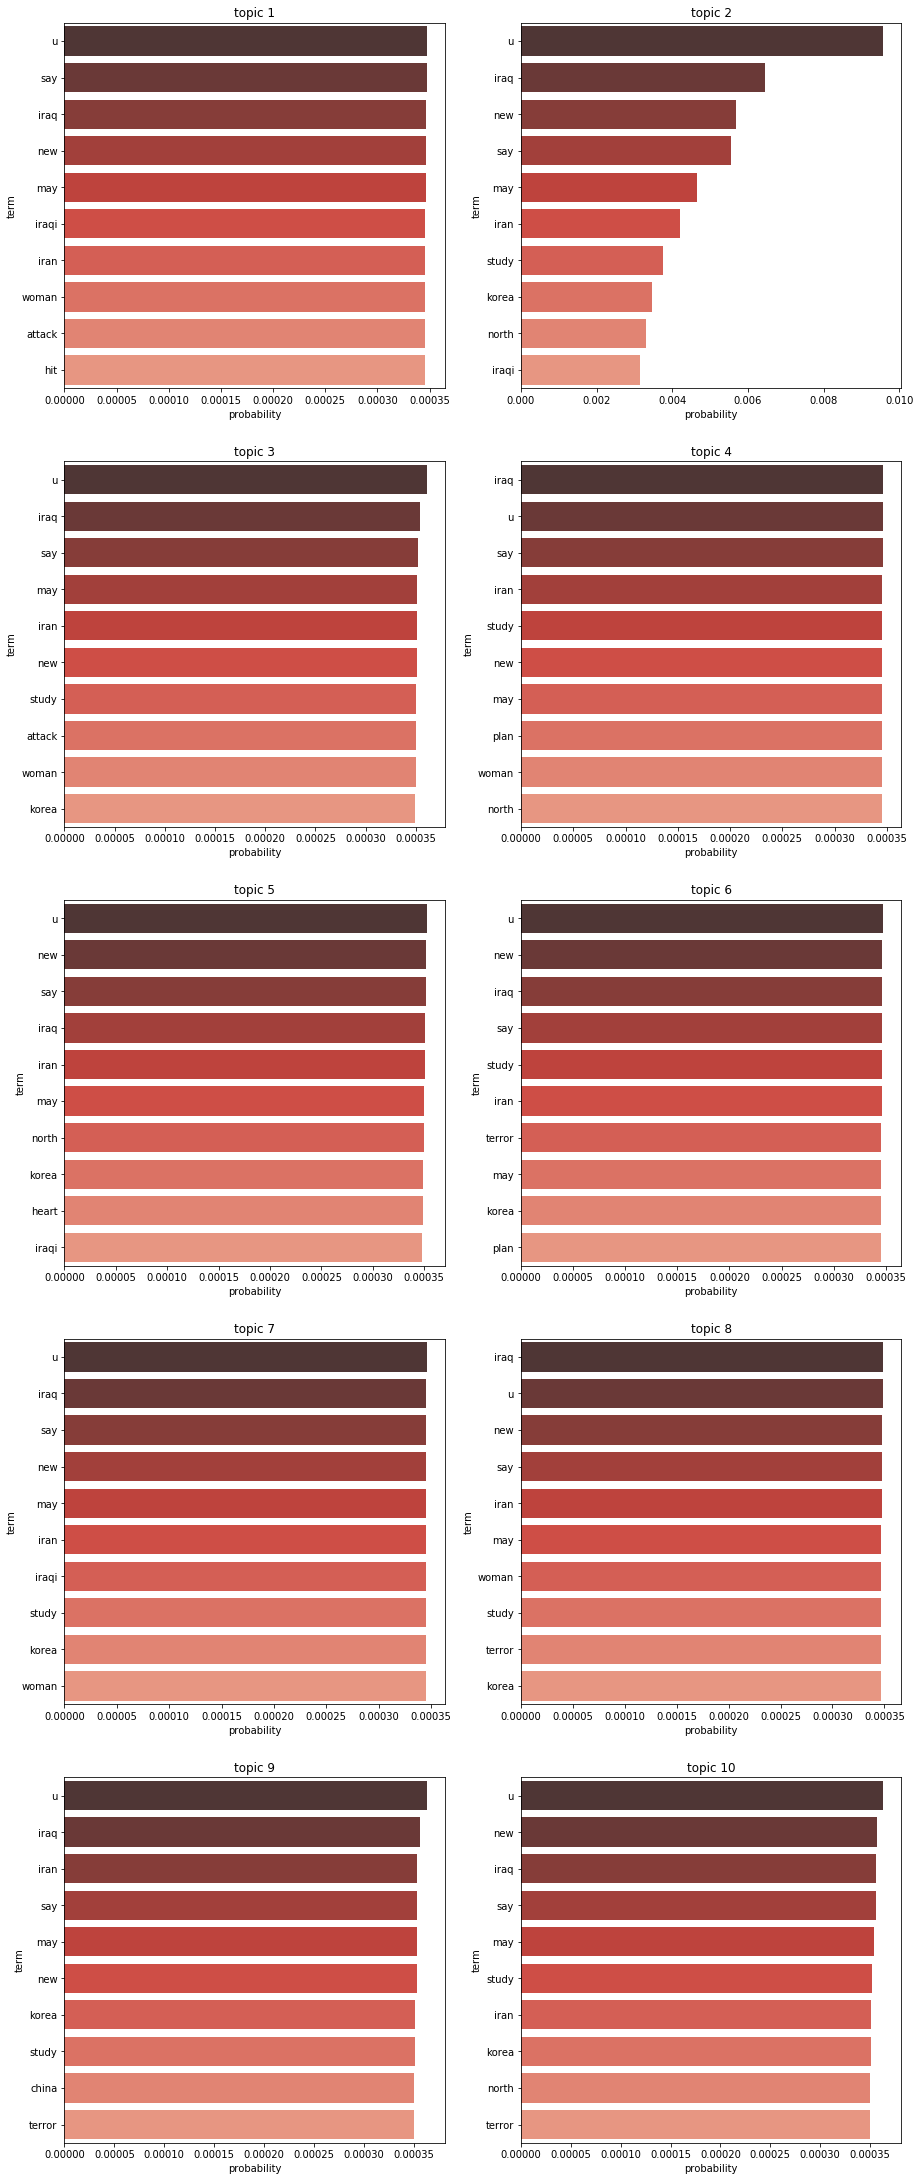

In [44]:
# show top topics
plt.show(words_importance(model_LDA))

In [45]:
pyLDAvis.enable_notebook() # view in Ipython

In [46]:
def viewModel(model, corpus, dictionary):
    return pyLDAvis.gensim.prepare(
        model, corpus, dictionary)

In [47]:
view_model = viewModel(model_LDA, corpus, dictionary)

In [ ]:
## use pyLDAvis.show() if pyLDAvis.display() does no work; igore warning
# pyLDAvis.display(view_model)
pyLDAvis.show(view_model) 


Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [13/May/2020 00:47:56] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [13/May/2020 00:48:03] "GET /LDAvis.css HTTP/1.1" 200 -
